### Imports

In [11]:
from collections import namedtuple, defaultdict
import gym
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tqdm import tqdm
import copy
import sys

### Gridworld

In [12]:
# Grid cell state and color mapping
EMPTY = BLACK = 0
WALL = GRAY = 1
AGENT = BLUE = 2
BOMB = RED = 3
GOAL = GREEN = 4

# RGB color value table
COLOR_MAP = {
    BLACK: [0.0, 0.0, 0.0],
    GRAY: [0.5, 0.5, 0.5],
    BLUE: [0.0, 0.0, 1.0],
    RED: [1.0, 0.0, 0.0],
    GREEN: [0.0, 1.0, 0.0],
}

# Action mapping
NOOP = 0
DOWN = 1
UP = 2
LEFT = 3
RIGHT = 4


class GridworldEnv(gym.Env):
    def __init__(self, max_steps=100):
        """Initialize Gridworld
        Args:
            max_steps (int, optional): Max steps per episode. Defaults to 100.
        """
        # Observations
        self.grid_layout = """
        1 1 1 1 1 1 1 1
        1 2 0 0 0 0 0 1
        1 0 1 1 1 0 0 1
        1 0 1 0 1 0 0 1
        1 0 1 4 1 0 0 1
        1 0 3 0 0 0 0 1
        1 0 0 0 0 0 0 1
        1 1 1 1 1 1 1 1
        """
        self.initial_grid_state = np.fromstring(self.grid_layout, dtype=int, sep=" ")
        self.initial_grid_state = self.initial_grid_state.reshape(8, 8)
        self.grid_state = copy.deepcopy(self.initial_grid_state)
        self.observation_space = gym.spaces.Box(
            low=0, high=6, shape=self.grid_state.shape
        )
        self.img_shape = [256, 256, 3]
        self.metadata = {"render.modes": ["human"]}
        # Actions
        self.action_space = gym.spaces.Discrete(5)
        self.actions = [NOOP, UP, DOWN, LEFT, RIGHT]
        self.action_pos_dict = defaultdict(
            lambda: [0, 0],
            {
                NOOP: [0, 0],
                UP: [-1, 0],
                DOWN: [1, 0],
                LEFT: [0, -1],
                RIGHT: [0, 1],
            },
        )
        (self.agent_state, self.goal_state) = self.get_state()
        self.step_num = 0  # To keep track of number of steps
        self.max_steps = max_steps
        self.done = False
        self.info = {"status": "Live"}
        self.viewer = None

    def step(self, action):
        """Return next observation, reward, done , info"""
        action = int(action)
        reward = 0.0

        next_state = (
            self.agent_state[0] + self.action_pos_dict[action][0],
            self.agent_state[1] + self.action_pos_dict[action][1],
        )

        next_state_invalid = (
            next_state[0] < 0 or next_state[0] >= self.grid_state.shape[0]
        ) or (next_state[1] < 0 or next_state[1] >= self.grid_state.shape[1])
        if next_state_invalid:
            # Leave the agent state unchanged
            next_state = self.agent_state
            self.info["status"] = "Next state is invalid"

        next_agent_state = self.grid_state[next_state[0], next_state[1]]

        # Calculate reward
        if next_agent_state == EMPTY:
            # Move agent from previous state to the next state on the grid
            self.info["status"] = "Agent moved to a new cell"
            self.grid_state[next_state[0], next_state[1]] = AGENT
            self.grid_state[self.agent_state[0], self.agent_state[1]] = EMPTY
            self.agent_state = copy.deepcopy(next_state)

        elif next_agent_state == WALL:
            self.info["status"] = "Agent bumped into a wall"
            reward = -0.1
        # Terminal states
        elif next_agent_state == GOAL:
            self.info["status"] = "Agent reached the GOAL "
            self.done = True
            reward = 1
        elif next_agent_state == BOMB:
            self.info["status"] = "Agent stepped on a BOMB"
            self.done = True
            reward = -1
        # elif next_agent_state == AGENT:
        else:
            # NOOP or next state is invalid
            self.done = False

        self.step_num += 1

        # Check if max steps per episode has been reached
        if self.step_num >= self.max_steps:
            self.done = True
            self.info["status"] = "Max steps reached"

        if self.done:
            done = True
            terminal_state = copy.deepcopy(self.grid_state)
            terminal_info = copy.deepcopy(self.info)
            _ = self.reset()
            return (terminal_state, reward, done, terminal_info)

        return self.grid_state, reward, self.done, self.info

    def reset(self):
        self.grid_state = copy.deepcopy(self.initial_grid_state)
        (
            self.agent_state,
            self.agent_goal_state,
        ) = self.get_state()
        self.step_num = 0
        self.done = False
        self.info["status"] = "Live"
        return self.grid_state

    def get_state(self):
        start_state = np.where(self.grid_state == AGENT)
        goal_state = np.where(self.grid_state == GOAL)

        start_or_goal_not_found = not (start_state[0] and goal_state[0])
        if start_or_goal_not_found:
            sys.exit(
                "Start and/or Goal state not present in the Gridworld. "
                "Check the Grid layout"
            )
        start_state = (start_state[0][0], start_state[1][0])
        goal_state = (goal_state[0][0], goal_state[1][0])

        return start_state, goal_state

    def gridarray_to_image(self, img_shape=None):
        if img_shape is None:
            img_shape = self.img_shape
        observation = np.random.randn(*img_shape) * 0.0
        scale_x = int(observation.shape[0] / self.grid_state.shape[0])
        scale_y = int(observation.shape[1] / self.grid_state.shape[1])
        for i in range(self.grid_state.shape[0]):
            for j in range(self.grid_state.shape[1]):
                for k in range(3):  # 3-channel RGB image
                    pixel_value = COLOR_MAP[self.grid_state[i, j]][k]
                    observation[
                        i * scale_x : (i + 1) * scale_x,
                        j * scale_y : (j + 1) * scale_y,
                        k,
                    ] = pixel_value
        return (255 * observation).astype(np.uint8)

    def render(self, mode="human", close=False):
        if close:
            if self.viewer is not None:
                self.viewer.close()
                self.viewer = None
            return

        img = self.gridarray_to_image()
        if mode == "rgb_array":
            return img
        elif mode == "human":
            from gym.envs.classic_control import rendering

            if self.viewer is None:
                self.viewer = rendering.SimpleImageViewer()
            self.viewer.imshow(img)

    def close(self):
        self.render(close=True)

    @staticmethod
    def get_action_meanings():
        return ["NOOP", "DOWN", "UP", "LEFT", "RIGHT"]

In [2]:
class Brain(keras.Model):
    def __init__(self, action_dim=5, input_shape=(1, 8 * 8)):
        """Initialize the Agent's Brain model

        Args:
            action_dim (int): Number of actions
        """
        super(Brain, self).__init__()
        self.dense1 = layers.Dense(32, input_shape=input_shape, activation="relu")
        self.logits = layers.Dense(action_dim)

    def call(self, inputs):
        x = tf.convert_to_tensor(inputs)
        logits = self.logits(self.dense1(x))
        return logits

    def process(self, observations):
        # Process batch observations using `call(inputs)` behind-the-scenes
        action_logits = self.predict_on_batch(observations)
        return action_logits

In [3]:
class Agent(object):
    def __init__(self, action_dim=5, input_shape=(1, 8 * 8)):
        """Agent with a neural-network brain powered policy

        Args:
            brain (keras.Model): Neural Network based model
        """
        self.brain = Brain(action_dim, input_shape)
        self.brain.compile(
            loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
        )
        self.policy = self.policy_mlp

    def policy_mlp(self, observations):
        observations = observations.reshape(1, -1)
        action_logits = self.brain.process(observations)
        action = tf.random.categorical(tf.math.log(action_logits), num_samples=1)
        return action  # tf.squeeze(action, axis=0)

    def get_action(self, observations):
        return self.policy(observations)

    def learn(self, obs, actions, **kwargs):
        self.brain.fit(obs, actions, **kwargs)

In [4]:
Trajectory = namedtuple("Trajectory", ["obs", "actions", "reward"])

In [5]:
# Evaluate agent in the given environment
def evaluate(agent, env, render=True):
    obs, episode_reward, done, step_num, info = env.reset(), 0.0, False, 0, None
    while not done:
        action = agent.get_action(obs)
        obs, reward, done, info = env.step(action)
        episode_reward += reward
        step_num += 1
        if render:
            env.render()
    return step_num, episode_reward, done, info

In [6]:
def rollout(agent, env, render=False):
    """Rollout `agent` in the `environment` for 1 episode
    Args:
        agent (Agent): Agent/policy to generate state-conditioned actions
        env (gym.Env): A Gym environment
        total_steps (int, optional): Totall number of steps to rollout. Defaults to 1000.
        render (bool, optional): Enable/disable rendering. Defaults to False.
    Returns:
        obs_batch (List): Batch of observations collected in the episode
        actions_batch (List): Batch of actions performed in the episode
        episode_reward (float): Total rewards accumulated in this episode
    """
    obs, episode_reward, done, step_num = env.reset(), 0.0, False, 0
    observations, actions = [], []
    episode_reward = 0.0
    while not done:
        action = agent.get_action(obs)
        next_obs, reward, done, info = env.step(action)
        # Save experience
        observations.append(
            np.array(obs).reshape(-1)
        )  # Convert to numpy & reshape (8, 8) to (1, 64)
        actions.append(np.squeeze(action, 0))
        episode_reward += reward

        obs = next_obs
        step_num += 1
        if render:
            env.render()
    env.close()
    return observations, actions, episode_reward

In [7]:
def gather_elite_xp(trajectories, elitism_criterion):
    """Gather elite trajectories from the batch of trajectories
    Args:
        batch_trajectories (List): List of episode trajectories containing experiences (obs, actions, episode_reward)
    Returns:
        elite_batch_obs
        elite_batch_actions
        elite_reard_threshold
    """
    trajectory_obs, trajectory_actions, trajectory_rewards = zip(*trajectories)
    reward_threshold = np.percentile(trajectory_rewards, elitism_criterion)
    indices = [
        index
        for index, value in enumerate(trajectory_rewards)
        if value >= reward_threshold
    ]

    elite_trajectory_obs = [trajectory_obs[i] for i in indices]
    elite_trajectory_actions = [trajectory_actions[i] for i in indices]
    unpacked_elite_batch_obs = [
        item for items in elite_trajectory_obs for item in items
    ]
    unpacked_elite_batch_actions = [
        item for items in elite_trajectory_actions for item in items
    ]
    return (
        np.array(unpacked_elite_batch_obs),
        np.array(unpacked_elite_batch_actions),
        reward_threshold,
    )

In [8]:
def gen_action_distribution(action_index, action_dim=5):
    action_distribution = np.zeros(action_dim).astype(type(action_index))
    action_distribution[action_index] = 1
    # action_distribution = np.expand_dims(action_distribution, 0)
    return action_distribution

In [16]:
def train(
    num_trajectory_rollouts=70,
    elitism_criterion=70,
    num_epochs=10,
):
    """Train Agent in the given Gym `env` using approximate Cross-Entropy

    Args:
        env (str, optional): Name of the Gym environment. Defaults to "Gridworld-v0".
        num_trajectory_rollouts (int, optional): Number of trajectories to rollouts/sample. Defaults to 70.
        elitism_criterion (int, optional): Threshold (as a percentage) to choose elites. Defaults to 70.
        num_epochs (int, optional): Number of epochs to train on the elite trajectories. Defaults to 10.
    """
    num_trajectory_rollouts = num_trajectory_rollouts
    elitism_criterion = elitism_criterion  # Percentage
    num_epochs = num_epochs

    # env = gym.make(env_id)
    env = GridworldEnv()
    agent = Agent(env.action_space.n, env.observation_space.shape)

    mean_rewards = []
    elite_reward_thresholds = []
    for i in tqdm(range(num_epochs)):
        trajectories = [
            Trajectory(*rollout(agent, env)) for _ in range(num_trajectory_rollouts)
        ]
        _, _, batch_rewards = zip(*trajectories)
        elite_obs, elite_actions, elite_threshold = gather_elite_xp(
            trajectories, elitism_criterion=elitism_criterion
        )
        elite_action_distributions = np.array(
            [gen_action_distribution(a.item()) for a in elite_actions]
        )
        elite_obs, elite_action_distributions = (
            elite_obs.astype("float16"),
            elite_action_distributions.astype("float16"),
        )
        agent.learn(
            elite_obs, elite_action_distributions, batch_size=128, epochs=3, verbose=0
        )
        mean_rewards.append(np.mean(batch_rewards))
        elite_reward_thresholds.append(elite_threshold)
        print(
            f"Episode#:{i + 1} elite-reward-threshold:{elite_reward_thresholds[-1]:.2f} reward:{mean_rewards[-1]:.2f} "
        )

    plt.plot(mean_rewards, "r-", label="mean_reward")
    plt.plot(elite_reward_thresholds, "g--", label="elites_reward_threshold")
    plt.legend()
    plt.grid()
    plt.show()

 50%|█████     | 1/2 [00:21<00:21, 21.53s/it]

Episode#:1 elite-reward-threshold:-4.00 reward:-4.26 


100%|██████████| 2/2 [00:42<00:00, 21.27s/it]

Episode#:2 elite-reward-threshold:-4.20 reward:-4.37 


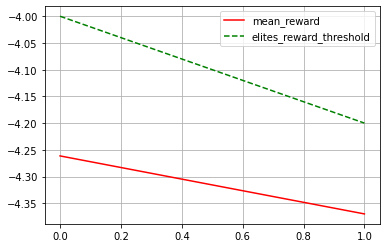

In [17]:
if __name__ == "__main__":
    train(num_epochs=2)  # Increase value of num_epochs

---

In [19]:
!pip install -q watermark
%reload_ext watermark
%watermark -a "Sparsh A." -m -iv -u -t -d

Author: Sparsh A.

Last updated: 2021-12-02 09:34:22

Compiler    : GCC 7.5.0
OS          : Linux
Release     : 5.4.104+
Machine     : x86_64
Processor   : x86_64
CPU cores   : 2
Architecture: 64bit

matplotlib: 3.2.2
keras     : 2.7.0
sys       : 3.7.12 (default, Sep 10 2021, 00:21:48) 
[GCC 7.5.0]
numpy     : 1.19.5
IPython   : 5.5.0
tensorflow: 2.7.0
gym       : 0.17.3



---

**END**